In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 42kB/s 


In [ ]:
import tensorflow as tf
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
!nvidia-smi

Fri Mar 12 06:49:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd

trainLabels = pd.read_csv("/content/drive/MyDrive/Diabetic Retinopathy Detection/sampleSubmission.csv")
trainLabels.head()

,image,level
0,1_left,0
1,1_right,0
2,2_left,0
3,2_right,0
4,3_left,0


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
#list the files in the input directory
print(os.listdir("/content/drive/MyDrive/Diabetic Retinopathy Detection"))
print(check_output(["ls", "/content/drive/MyDrive/Diabetic Retinopathy Detection/trainLabels.csv"]).decode("utf8")) #trainLabels.csv
print(check_output(["pwd", ""]).decode("utf8")) 
#classes : 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

['trainLabels.csv', 'sampleSubmission.csv', 'sample', 'train', 'trainLabelsTrain.csv', 'trainLabels1.csv', 'train1', 'Deployment-Deep-Learning-Model-master']
/content/drive/MyDrive/Diabetic Retinopathy Detection/trainLabels.csv

/content



In [ ]:
NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []
def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    images = os.listdir(trainDir)
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "sampleSubmission.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(os.path.sep, trainDir, imageFileName)
        #print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  # Numpy array with shape (233,233,3)
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape) # 128,128,3
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr))
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
    return

In [ ]:
from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
readTrainData("/content/drive/MyDrive/Diabetic Retinopathy Detection/train")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now())) # 1500


Loading images at...2021-03-12 06:51:06.124898
Number of files in /content/drive/MyDrive/Diabetic Retinopathy Detection/train is 1500
Loaded 1500 images at...2021-03-12 07:04:52.155123


In [ ]:
#csv contains image	level
#10_left 0
#10_right 0
import csv
def readTrainCsv():
    raw_df = pd.read_csv('/content/drive/MyDrive/Diabetic Retinopathy Detection/trainLabels.csv', sep=',')
    print(type(raw_df)) #<class 'pandas.core.frame.DataFrame'>
    row_count=raw_df.shape[0] #gives number of row count row_count=35126 
    col_count=raw_df.shape[1] #gives number of col count col count=2
    print("row_count="+str(row_count)+" col count="+str(col_count))
    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list) # ['image', 'level', 'PatientID']
    # double check if level of left and right are same or not
    ImageLevelHash = {}
    patientIDList = []
    for index, row in raw_df.iterrows():
        # 0 is image, 1 is level, 2 is PatientID, 3 is data
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
        #print("Adding patient ID"+ patientID)
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) # level
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))
    count=0;
    for patientID in uniquePatientIDList:
        left_level = ImageLevelHash[str(patientID+'_left')]
        right_level = ImageLevelHash[str(patientID+'_right')]
        #right_exists = str(patientID+'_right') in raw_df.values
        if (left_level != right_level):
            count = count+1
            #print("Warning for patient="+ str(patientID) + " left_level=" + left_level+ " right_level=" +right_level)
    print("count of images with both left and right eye level not matching="+str(count)) # 2240
    print("number of unique patients="+str(len(uniquePatientIDList))) # 17563
    return raw_df

In [ ]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count=35126 col count=2
['image', 'level', 'PatientID']
count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [ ]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] # get patient id of patients
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [ ]:
# df has 3 columns ['image', 'level', 'PatientID']
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 1500

1500


In [ ]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) # np.array

df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) # ['image', 'data']
print(len(df2)) # 1000
print(df2.describe(include='all'))
print(df2.sample(3)) # 3 rows x 2 columns

['image', 'data']
1500
             image                                               data
count         1500                                               1500
unique        1500                                               1500
top     2425_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
freq             1                                                  1
           image                                               data
812    2812_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
602    2553_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1206  19930_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...


In [ ]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [ ]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list) # 'image', 'data', level', 'PatientID'
print(len(df)) # 1500
print(df.sample())

['image', 'data', 'level', 'PatientID']
1500
            image  ... PatientID
1465  20209_right  ...     20209

[1 rows x 4 columns]


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
<class 'numpy.ndarray'>
(128, 128, 3)


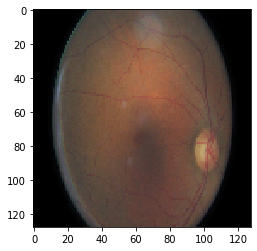

Sample Image


In [ ]:
sample0 = df.loc[df.index[12], 'data']
print(sample0)
print(type(sample0)) # <class 'numpy.ndarray'>
print(sample0.shape) # 128,128,3
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [ ]:
X = df['data']
Y = df['level']
# scale the raw pixel intensities to the range [0, 1]
#print(type(X)) # 'pandas.core.series.Series'
#X = np.array(X, dtype="float") / 255.0 -- TBD moved to top
Y = np.array(Y)
# convert the labels from integers to vectors
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [ ]:
# partition the data into training and testing splits using 75% training and 25% for validation
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) #
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids))) #

train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) #stratify = rr_df['level'])
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list))) # 

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=750
unique_ids shape=750
trainid_list shape= 562


In [ ]:
print(traindf.head())
print(valSet.head())

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

      image                                               data  level PatientID
0   19_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        19
1  19_right  [[[0.0, 0.0, 0.0], [0.0, 0.00784313725490196, ...      0        19
4   21_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        21
5  21_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        21
6   22_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        22
        image  ... PatientID
2     20_left  ...        20
3    20_right  ...        20
12   195_left  ...       195
13  195_right  ...       195
14   197_left  ...       197

[5 rows x 4 columns]
      image                                               data  level PatientID
0   19_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        19
1  19_right  [[[0.0, 0.0, 0.0], [0.0, 0.00784313725490196, ...      0        19
2   21_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0        21
3  2

In [ ]:
trainX = traindf['data']
trainY = traindf['level']

valX = valSet['data']
valY = valSet['level']

#(trainX, valX, trainY, valY) = train_test_split(X,Y,test_size=0.25, random_state=10)
print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0]) # train and val

trainX shape= 1124 valX shape= 376


In [ ]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [ ]:
#construct the image generator for data augmentation
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")


Generating images...


In [ ]:
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
print("Reshaping trainX at..."+ str(datetime.now()))
#print(trainX.sample()) 
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) # (750,)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
print(Xtrain.shape) # (750,128,128,3)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2021-03-12 07:10:27.130083
<class 'pandas.core.series.Series'>
(1124,)
(1124, 128, 128, 3)
Reshaped trainX at...2021-03-12 07:10:27.454920


In [ ]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX)) # <class 'pandas.core.series.Series'>
print(valX.shape) # (250,)
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]): # 0 to traindf Size -1
    Xval[i] = valX[i]
print(Xval.shape) # (250,128,128,3)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2021-03-12 07:10:29.033121
<class 'pandas.core.series.Series'>
(376,)
(376, 128, 128, 3)
Reshaped valX at...2021-03-12 07:10:29.144958


compiling model...


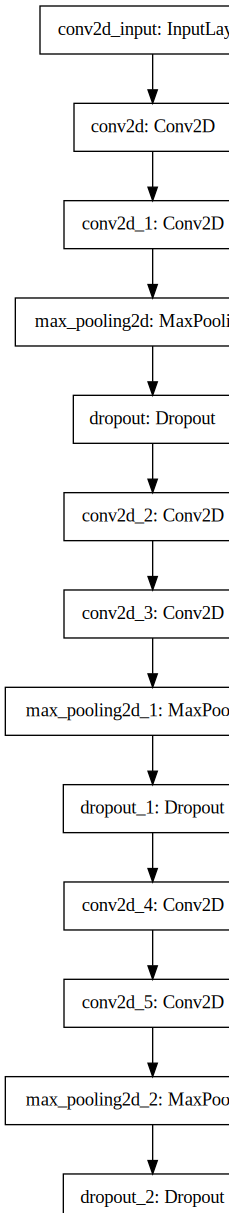

In [ ]:
# initialize the model
print("compiling model...")
sys.stdout.flush()
model = createModel()

# print the summary of model
#from keras.utils import print_summary
#print_summary(model, line_length=None, positions=None, print_fn=None)

# add some visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
!pip install np_utils

In [ ]:
# train the network
print("training network...")
sys.stdout.flush()

#class_mode ='categorical', # 2D one-hot encoded labels
H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("Saving model to disk")
sys.stdout.flush()
tf.keras.models.save_model(model, 'my_model2.hdf5')

training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
35/35 [==============================] - 39s 158ms/step - loss: 1.0145 - accuracy: 0.7061 - val_loss: 0.8082 - val_accuracy: 0.7686
Epoch 2/15
35/35 [==============================] - 4s 126ms/step - loss: 0.8242 - accuracy: 0.7659 - val_loss: 0.7990 - val_accuracy: 0.7686
Epoch 3/15
35/35 [==============================] - 4s 127ms/step - loss: 0.8233 - accuracy: 0.7531 - val_loss: 0.8252 - val_accuracy: 0.7686
Epoch 4/15
35/35 [==============================] - 5s 130ms/step - loss: 0.8361 - accuracy: 0.7640 - val_loss: 0.8177 - val_accuracy: 0.7686
Epoch 5/15
35/35 [==============================] - 4s 126ms/step - loss: 0.7761 - accuracy: 0.7741 - val_loss: 0.8121 - val_accuracy: 0.7686
Epoch 6/15
35/35 [==============================] - 5s 128ms/step - loss: 0.7926 - accuracy: 0.7748 - val_loss: 0.8028 - val_accuracy: 0.7686
Epoch 7/15
35/35 [==============================] - 4s 128ms/step - loss: 0.8134 - accuracy: 0.7617 - val_loss: 0.8125 - val_accuracy: 0.7686
Epoch

Generating plots...


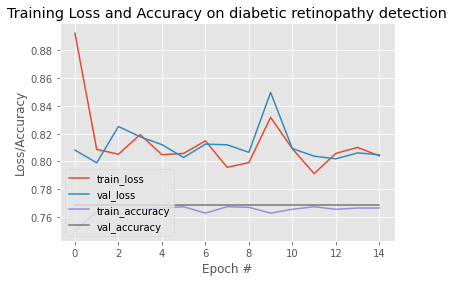

In [ ]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

In [ ]:
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
print("Reshaping trainX at..."+ str(datetime.now()))
#print(trainX.sample()) 
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) # (750,)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
print(Xtrain.shape) # (750,128,128,3)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2021-03-12 07:12:50.651745
<class 'pandas.core.series.Series'>
(1124,)
(1124, 128, 128, 3)
Reshaped trainX at...2021-03-12 07:12:50.929149


In [ ]:
# train the network
print("training network...")
sys.stdout.flush()
#class_mode ='categorical', # 2D one-hot encoded labels
H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("Saving model to disk")
sys.stdout.flush()
tf.keras.models.save_model(model, 'my_model3.hdf5')

training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
35/35 [==============================] - 5s 130ms/step - loss: 0.8128 - accuracy: 0.7647 - val_loss: 0.8169 - val_accuracy: 0.7686
Epoch 2/15
35/35 [==============================] - 4s 128ms/step - loss: 0.7991 - accuracy: 0.7692 - val_loss: 0.8071 - val_accuracy: 0.7686
Epoch 3/15
35/35 [==============================] - 5s 128ms/step - loss: 0.8191 - accuracy: 0.7619 - val_loss: 0.8323 - val_accuracy: 0.7686
Epoch 4/15
35/35 [==============================] - 5s 129ms/step - loss: 0.8018 - accuracy: 0.7656 - val_loss: 0.8054 - val_accuracy: 0.7686
Epoch 5/15
35/35 [==============================] - 4s 127ms/step - loss: 0.8015 - accuracy: 0.7647 - val_loss: 0.8043 - val_accuracy: 0.7686
Epoch 6/15
35/35 [==============================] - 4s 124ms/step - loss: 0.8044 - accuracy: 0.7656 - val_loss: 0.8042 - val_accuracy: 0.7686
Epoch 7/15
35/35 [==============================] - 4s 126ms/step - loss: 0.8008 - accuracy: 0.7637 - val_loss: 0.8134 - val_accuracy: 0.7686
Epoch 

Generating plots...


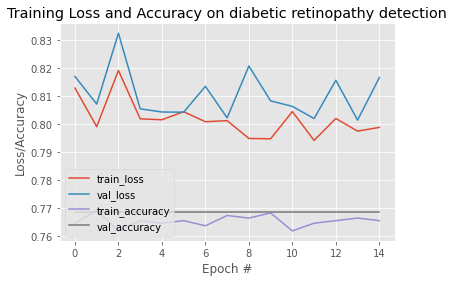

In [ ]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot2.png")

In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
def cache(*args, **kwargs):
    def decorator(func):
        try:
            __IPYTHON__  # type: ignore
            # We are in a Jupyter environment, so don't apply st.cache
            return func
        except NameError:
            return st.cache(func, *args, **kwargs)

    return decorator
@cache()
def long_running_function():
    return 1

def load_model():
  model = tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
model=load_model()
st.write("""
        # Diabetic Retinopathy Detection
        """
        )
#file = st.file_uploader("Please upload an retinal image", type = ["jpeg","jpg","png"])
file = "/content/drive/MyDrive/Copy_203_right.jpeg"
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):

  size = (128,128)
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  img = np.asarray(image)
  img_reshape = img[np.newaxis,...]
  prediction = model.predict(img_reshape)

  return prediction

if file is None:
  st.text("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)
  predictions = import_and_predict(image, model)
  class_names = ['No DR','Mild','Moderate','Severe','Proliferative DR']
  string = "This image is most likely is: "+class_names[np.argmax(predictions)]
  print(np.argmax(predictions))
  print(class_names[np.argmax(predictions)])

2021-03-12 07:15:34.491 WARNING root: 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]


0
No DR
